In [179]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from torch.optim import lr_scheduler

In [1]:
from IPython.display import Image
# get the image
Image(url="photos/photo_henrique.jpg", width=400)

In [181]:
data_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

data_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

In [182]:
# Método usual para utilizar dataset em Pandas direto com o Dataloader

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x, y

In [183]:
# Instancia objeto para os iteradores do DataLoader
train_dataset = CustomDataset(data_train)
test_dataset = CustomDataset(data_test)

In [184]:
# Calcula peso que deve ser dado para a classe com rótulo igual a '1' (importante para melhorar classificação de '1')
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(data_train.iloc[:, -1].values), y = data_train.iloc[:, -1].values)
class_weights=torch.tensor(class_weights[1],dtype=torch.float)
 
print(class_weights)

tensor(1.4018)


In [185]:
Nb = 64
# Carrega datasets
train_loader = DataLoader(train_dataset, batch_size=Nb, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Nb, shuffle=False)

In [186]:
class ModelSimple(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Entrada com 8 elementos, sem função de ativação
            nn.Linear(8, 1)
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [187]:
class ModelComplex(nn.Module):
    def __init__(self, neurons_list, args):
        super().__init__()
        
        self.neurons_list = neurons_list
        
        self.n_layers = len(neurons_list)

        self.args = args

        
        self.layers = nn.ModuleDict()
        self.layers["input"] = nn.Linear(in_features = 8, out_features = neurons_list[0])

        # Itera sobre a lista de neurônios e os conecta, também coloca o que estiver em args para cada camada
        for i in range(self.n_layers-1):
            self.layers[f"hidden_{i}"] = nn.Sequential(
                                         nn.Linear(neurons_list[i], neurons_list[i+1]),
                                         nn.BatchNorm1d(neurons_list[i+1]),
                                         *args)

        self.layers["output"] = nn.Linear(in_features=neurons_list[-1], out_features=1)
        
    def forward(self, x):
        x = self.layers["input"](x)
        
        # Loop para aplicar as camadas criadas
        for i in range(self.n_layers-1):
            x = self.layers[f"hidden_{i}"](x)

        return self.layers["output"](x)

In [188]:
def train(model, filename, num_epochs = 100, learning_rate = 0.1):
    # Define the training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Note que a função custo está com peso class_weights para a classe positiva ('1')
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights) 

    # Otimizador ADAM visto em aula
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning Rate variável com decaimento exponencial, a cada época o novo valor é 95% do anterior.
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1) # Necessário para ajustar dimensões do problema

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Média do training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validação
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1) # Necessário para ajustar dimensões do problema

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item()

        # Média do validation loss
        valid_loss /= len(test_loader)
        valid_losses.append(valid_loss)

        # Ajusta learning rate
        scheduler.step()
        
        # Exibe os resultados da época (feito de forma que sempre teremos 10 prints na tela)
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

    # Salva Modelo
    torch.save(model.state_dict(), filename)

    # Plots
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [189]:
def test(model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Carrega pesos no modelo
    model.load_state_dict(torch.load(filename))
    model.eval()
    total_correct = 0
    total_samples = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            # Calcula predição, sigmoide aplicado pois estamos utilizando logits
            predicted = torch.round(torch.sigmoid(outputs))

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calcula accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test Accuracy: {accuracy * 100:.2f} %')

    # Calculaprecision
    precision = precision_score(true_labels, predicted_labels)
    print(f'Test Precision: {precision*100:.2f} %')

    # Calcula recall
    recall = recall_score(true_labels, predicted_labels)
    print(f'Test recall: {recall*100:.2f} %')

    # Calcula F1-score
    f1 = f1_score(true_labels, predicted_labels)
    print(f'Test F1-score: {f1*100:.2f} %')

    # Calcula confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion)
    disp.plot()
    print('Test Confusion Matrix:')
    print(confusion)
    plt.show()

    return accuracy, precision, recall, f1

Epoch 10/100 - Train Loss: 0.9442 - Valid Loss: 0.7678
Epoch 20/100 - Train Loss: 0.7319 - Valid Loss: 0.6555
Epoch 30/100 - Train Loss: 0.6859 - Valid Loss: 0.6158
Epoch 40/100 - Train Loss: 0.6643 - Valid Loss: 0.6143
Epoch 50/100 - Train Loss: 0.7102 - Valid Loss: 0.6585
Epoch 60/100 - Train Loss: 0.6535 - Valid Loss: 0.6094
Epoch 70/100 - Train Loss: 0.6461 - Valid Loss: 0.6121
Epoch 80/100 - Train Loss: 0.6433 - Valid Loss: 0.6132
Epoch 90/100 - Train Loss: 0.6418 - Valid Loss: 0.6137
Epoch 100/100 - Train Loss: 0.6409 - Valid Loss: 0.6140


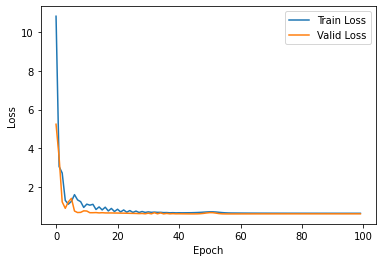

In [190]:
train(ModelSimple(), "model_simple.pt", num_epochs = 100)

Test Accuracy: 74.68 %
Test Precision: 58.93 %
Test recall: 67.35 %
Test F1-score: 62.86 %
Test Confusion Matrix:
[[82 23]
 [16 33]]


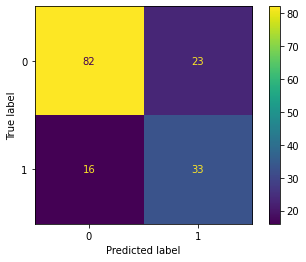

(0.7467532467532467, 0.5892857142857143, 0.673469387755102, 0.6285714285714286)

In [191]:
test(ModelSimple(), "model_simple.pt")

Epoch 10/100 - Train Loss: 0.6338 - Valid Loss: 0.6134
Epoch 20/100 - Train Loss: 0.5950 - Valid Loss: 0.6063
Epoch 30/100 - Train Loss: 0.5879 - Valid Loss: 0.6167
Epoch 40/100 - Train Loss: 0.5587 - Valid Loss: 0.6170
Epoch 50/100 - Train Loss: 0.5997 - Valid Loss: 0.6152
Epoch 60/100 - Train Loss: 0.5921 - Valid Loss: 0.6149
Epoch 70/100 - Train Loss: 0.5621 - Valid Loss: 0.6188
Epoch 80/100 - Train Loss: 0.5629 - Valid Loss: 0.6201
Epoch 90/100 - Train Loss: 0.5572 - Valid Loss: 0.6204
Epoch 100/100 - Train Loss: 0.5751 - Valid Loss: 0.6200


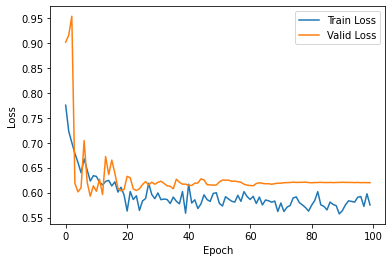

In [202]:
# Define camada oculta da rede
neuron_list = [8, 16, 8]

# Define dropout e função de ativação da camada oculta
activation_function = nn.Sigmoid()
dropout = nn.Dropout(0.5)

args = [activation_function, dropout]

model_complex = ModelComplex(neuron_list, args)

train(model_complex, "model_complex.pt", num_epochs = 100)

Test Accuracy: 77.27 %
Test Precision: 64.00 %
Test recall: 65.31 %
Test F1-score: 64.65 %
Test Confusion Matrix:
[[87 18]
 [17 32]]


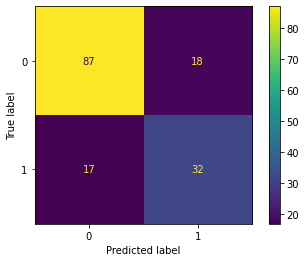

(0.7727272727272727, 0.64, 0.6530612244897959, 0.6464646464646464)

In [203]:
test(model_complex, "model_complex.pt")

## Rede Simples

A rede simples, com um único neurônio, obtêm resultados muito próximos em todas os treinos. 
Em média, o resultado da rede simples, treinando com BCELossWithLogits (com peso para melhorar treinamento para classe '1'), ExponentialLR e otimizador ADAM é:

Acurácia = $74.68 \%$

Precision = $58.93 \%$

Recall = $67.35 \%$

F1-score = $62.86 \%$

Confusion Matrix:
$$
\left[\begin{matrix}
82 & 23 \\
16 & 33
\end{matrix}\right]
$$

## Rede Complexa

A rede complexa introduz **dropout**, **normalização de batch** e **camadas ocultas** (8, 16, 8). Testou-se diversas combinaões de camadas ocultas mas em geral não houve ganhos ao aumentar a camada oculta excessivamente.

Acurácia = $77.27 \%$

Precision = $64.00 \%$

Recall = $65.31 \%$

F1-score = $64.65\%$

Confusion Matrix:
$$
\left[\begin{matrix}
87 & 18 \\
17 & 32
\end{matrix}\right]
$$

## Resumo das técnicas utilizadas
- **Função de custo**: BCELossWithLogits com pesos para classe '1'

- **Função de ativação**: Sigmoid()

- **Técnicas adicionais**: Dropout() e Learning Rate variável (exponencial)

## Comentários finais

Uma das alterações que permitiu desempenho razoável das redes foi o ajuste de pesos para as classes iguais a '1', dado que o dataset possue menos exemplos dessa classe o treinamento muitas vezes enviezava para a classe '0', detectando somente saídas iguais a '0'. O uso de pesos permitiu aumentar a revocação da rede, detectando melhor os rótulos iguais '1'.
Algumas treinamentos chegaram próximos de 80% de acurácia, entretanto esses modelos tendiam muito para a classificação de uma única classe. O objetivo dos ajustes realizados foi equilibrar o modelo para que ele possa detectar ambas as classes de forma parecida.